Import statements

In [2]:
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import os
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


Download the database

In [4]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

Extract the downloaded file

In [5]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Define Classes for model



In [3]:


# accuracy(outputs, labels) returns the accuracy score of the model's outputs and the images' labels
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# to_device(data, device) move data to device (namely GPU, if one is available)
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# To define the model, we first have to define the basis of the model - ImageClassificationBase class
# This class will contain many helper functions to calculate the errors between the image's label and the model's output
class ImageClassificationBase(nn.Module):
    # training_step(self, batch) returns the average difference between the actual image label and the model's output
    # FOR USE BY THE training_ds
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    # validation_step(self, batch) returns the average difference between the image's label and the model's output.
    # As well as teh accuracy of the label
    # FOR USE BY THE validation_ds
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    # validation_epoch_end(self, outputs) returns the average error between the image's label adn the model's output
    # across the training batches
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# CnnModel used to classify image, extended from ImageClassificationBase
class Cifar10CnnModel(ImageClassificationBase):
    # We use nn.Sequential to chain together the neural network's layers and the activation functions (aka ReLU())
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Halves the image
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Halves the image again
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Halves the image again!
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4


            nn.Flatten(), # flatten the 2D array into a 1D vector for ease of proccessing by the neural network
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

# DeviceDataLoader wrap a dataload to move data to a device (GPU) if one is available
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    # __iter__(self) yield a batch of data after moving it to device        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    # __len__(self) returns the number of batches in the set
    def __len__(self):

        return len(self.dl)

Verify information about the dataset


In [6]:
data_dir = "./data/cifar10"
print("The directories are: ", os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print("Classes: ",classes)

airplane_test_files = os.listdir(data_dir+"/test/airplane")
airplane_train_files = os.listdir(data_dir+"/train/airplane")
print("No. airplane test files: ", len(airplane_test_files))
print("No. airplane train files: ", len(airplane_train_files))

dataset = ImageFolder(data_dir+"/train", transform=ToTensor())


The directories are:  ['train', 'test']
Classes:  ['ship', 'airplane', 'frog', 'automobile', 'cat', 'horse', 'deer', 'truck', 'dog', 'bird']
No. airplane test files:  1000
No. airplane train files:  5000


Displaying images in the terminal

In [7]:
# Set parameters for matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# show_example(img, label) displays the image in the terminal
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Generating random validation set

In [8]:
# To ensure we always create the same validation set, we'll set a seed for the random number generator
random_seed = 42
torch.manual_seed(random_seed)

# Preset validation set's size
val_size = 5000
train_size = len(dataset) - val_size

# Split training set for validation set
train_ds, val_ds = random_split(dataset, [train_size, val_size])
# print(len(train_ds), len(val_ds))

# Create data loaders for training and validation, to load the data in batches
batch_size = 128

# Data loaders for trainning and validation sets
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Set up kernels and training datasets

In [9]:

# apply_kernel(img, kernel) returns an array of values as a result of applying the kernel
# onto img

# kernel is an n by n array with pre-populated values inside it. By applying the kernel onto img,
# We multiply each cell in the kernel's region with kernel cell's value (at the position), then slide
# the kernel over to another group of cell, this is otherwise referred to as the "Sliding Window Algorithm"

def apply_kernel(img, kernel):
    ri, ci = img.shape # retrieve the image's dimension
    rk, ck = kernel.shape # retrieve the kernel's dimension
    ro, co = ri-rk+1, ci-ck+1 # retrieve the output dimensions

    # set up the output array
    output = torch.zeros([ro, co])

    # apply the kernel to every window of the image
    for i in range(ro):
        for j in range(co):
            # calculate cell's value 
            output[i,j] = torch.sum(img[i:i+rk,j:j+ck] * kernel)
    
    return output

# get_default_device() returns the GPU device of the "host machine" if 
# a GPU is available, otherwise, it returns a CPU
# It helps maximize the training speed of the model, as well as the use 
# of the host machine

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# PREPARING THE DATA FOR TRAINING

# define the model by setting it equal to the instance of the Cifar10CNNModel() class
model = Cifar10CnnModel()

# set device (CPU or GPU) for training the model
device = get_default_device()

# Re-define train_dl and val_dl such that the program would move the model to the GPU to
# speed up the training process (if a GPU is available) 
# => lower the workload for CPU
# => decrease the training time
# => increase the time efficiency

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# move the model to the device
to_device(model, device)

# TRAIN THE MODEL

@torch.no_grad()
# evaluate(model, val_loader) evaluate the accuracy of the model
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD) fits the data to the model
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase 

        # The model will be re-trained for each epoch => The accuracy would increase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# EVALUATION 
model = to_device(Cifar10CnnModel(), device)

# Evaluate the model against the validation dataset
# evaluate(model, val_dl)

# Output: {'val_loss': 2.3029751777648926, 'val_acc': 0.10143611580133438}
# => ~10% accurracy

# WE ARE DONE!!!!!!!!!!!!

# ARE WE? 

# NOOOOOOOOOOOOOO!!!!!!!!!!

# The initial model would only have 10% of accuracy score

# WHY?

# The model is randomly initialized, there are 10 classes, and there is only 1 right answer
# => An accuracy score of 10% makes sense! 

# HOW CAN WE IMPROVE THE ACCURACY POINT THEN?

#  => Increase epochs, so the model got re-trained more, the weights are better adjusted

#  => Decrease learning rate, so the model learns slower, which requires more epochs, but also helps 
# it to better recognize more patterns and increase the accuracy

# => Change the optimal function, so the function's prediction are more optimal. There are 
# various types of optimal functions, which are good for various different purposes of the model

# INCREASE ACCURACY PHASE

# Pre-set hyperparameters
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

Test the model


In [10]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

# plot_losses(history) plots the Loss vs. No. of epochs
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

# plot_accuracies(history) plots the Accuracy vs. No. of epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
  


Epoch [0], train_loss: 1.7081, val_loss: 1.3520, val_acc: 0.5084
Epoch [1], train_loss: 1.1791, val_loss: 1.0762, val_acc: 0.6048
Epoch [2], train_loss: 0.9282, val_loss: 0.8817, val_acc: 0.6894
Epoch [3], train_loss: 0.7620, val_loss: 0.8040, val_acc: 0.7210
Epoch [4], train_loss: 0.6286, val_loss: 0.7307, val_acc: 0.7447
Epoch [5], train_loss: 0.5212, val_loss: 0.7002, val_acc: 0.7617
Epoch [6], train_loss: 0.4216, val_loss: 0.6830, val_acc: 0.7755
Epoch [7], train_loss: 0.3281, val_loss: 0.8130, val_acc: 0.7605
Epoch [8], train_loss: 0.2557, val_loss: 0.7694, val_acc: 0.7733
Epoch [9], train_loss: 0.2010, val_loss: 0.8683, val_acc: 0.7756
Epoch [10], train_loss: 0.1648, val_loss: 0.9931, val_acc: 0.7708
Epoch [11], train_loss: 0.1269, val_loss: 1.0370, val_acc: 0.7617
Epoch [12], train_loss: 0.1180, val_loss: 1.1637, val_acc: 0.7734
Epoch [13], train_loss: 0.0952, val_loss: 1.1669, val_acc: 0.7697
Epoch [14], train_loss: 0.0961, val_loss: 1.1996, val_acc: 0.7642
Epoch [15], train_lo

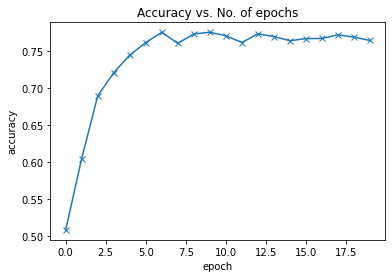

In [11]:
plot_accuracies(history)


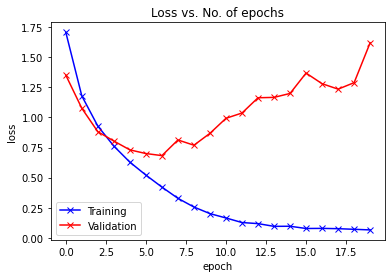

In [12]:
plot_losses(history)